In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from datetime import datetime

In [158]:
df3 = pd.read_csv('../données_brut/export_rdv_2023-01-01-2023-12-31.csv', sep=';')
df3['Date de saisie'] = df3['Date de saisie'].str[:10]
new_df = pd.DataFrame({'Statut': df3['Statut'], 
                       'Motif du RDV': df3['Motif du RDV'], 'Date de saisie': df3['Date de saisie'], 'Date de début': df3['Date de début']})
day_map = {
    'Absent excusé': 'Absent excusé',
    'Absent non excusé': 'Absent non excusé',
    'Vu' : 'Présent',
    'À déplacer': 'Absent excusé',
    'À venir': 'Absent non excusé',
    'En attente': 'Présent',
    'En consultation': 'Présent'    
}
new_df['Statut'] = new_df['Statut'].map(day_map)

/tmp/ipykernel_60286/703534327.py:1: DtypeWarning: Columns (45,46,47,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('../données_brut/export_rdv_2023-01-01-2023-12-31.csv', sep=';')


In [159]:
new_df['Date de saisie'] = pd.to_datetime(new_df['Date de saisie'])
new_df['Date de début'] = pd.to_datetime(new_df['Date de début'], format = "%d/%m/%Y")

In [160]:
new_df['Difference (days)'] = (new_df['Date de début'] - new_df['Date de saisie']).dt.days
print(new_df['Difference (days)'] )

0         4
1         1
2        33
3         1
4         3
         ..
23783    61
23784    53
23785    42
23786     1
23787    35
Name: Difference (days), Length: 23788, dtype: int64


In [161]:
new_df.head()

,Statut,Motif du RDV,Date de saisie,Date de début,Difference (days)
0,Absent excusé,Adulte - Consultation de médecine générale,2022-12-29,2023-01-02,4
1,Présent,Première consultation de gynécologie,2023-01-01,2023-01-02,1
2,Présent,Consultation de suivi d'allergologie,2022-11-30,2023-01-02,33
3,Présent,Urgence,2023-01-01,2023-01-02,1
4,Absent excusé,Adulte - Consultation de médecine générale,2022-12-30,2023-01-02,3


In [162]:
new_df.dropna(inplace=True)
new_df= new_df[new_df['Motif du RDV'].isin(['Adulte - Consultation de médecine générale','enfant/ado - consultation de médecine générale', 'Consultation de médecine du sport',"Certificat d'aptitude au sport"])]

In [163]:
dd = new_df[new_df["Difference (days)"] == 3]
dd.count()

Statut               521
Motif du RDV         521
Date de saisie       521
Date de début        521
Difference (days)    521
dtype: int64

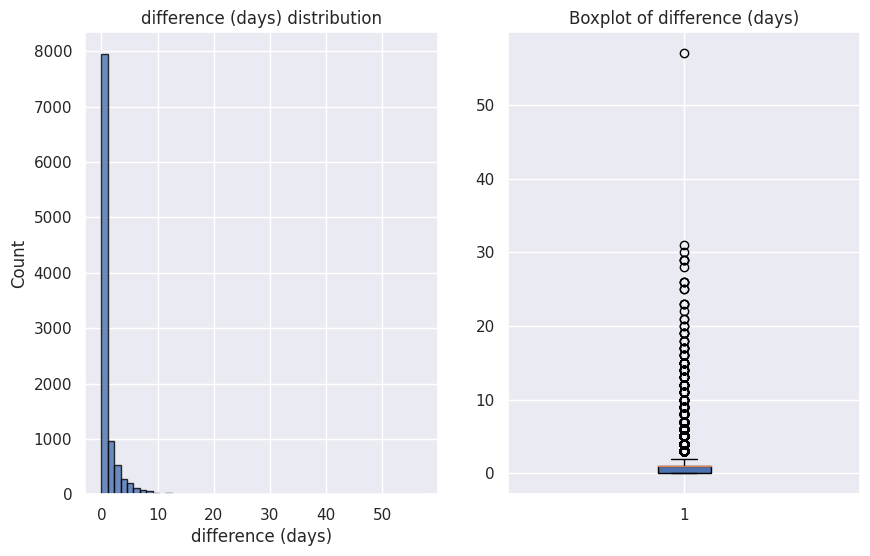

In [164]:
sns.set_theme("notebook")

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(new_df['Difference (days)'], bins=50, edgecolor='black', alpha=0.8)
# Ajouter des labels et un titre
plt.xlabel('difference (days)')
plt.ylabel('Count')
plt.title('difference (days) distribution')
# Afficher l'histogramme

plt.subplot(1, 2, 2)
plt.boxplot(new_df['Difference (days)'],patch_artist=True)
plt.title('Boxplot of difference (days)')    

plt.show()

### Log tranformation
- On utilise la transformation logarithmique pour réduire l'effet des valeurs extrêmes et rendre les données plus visibles.

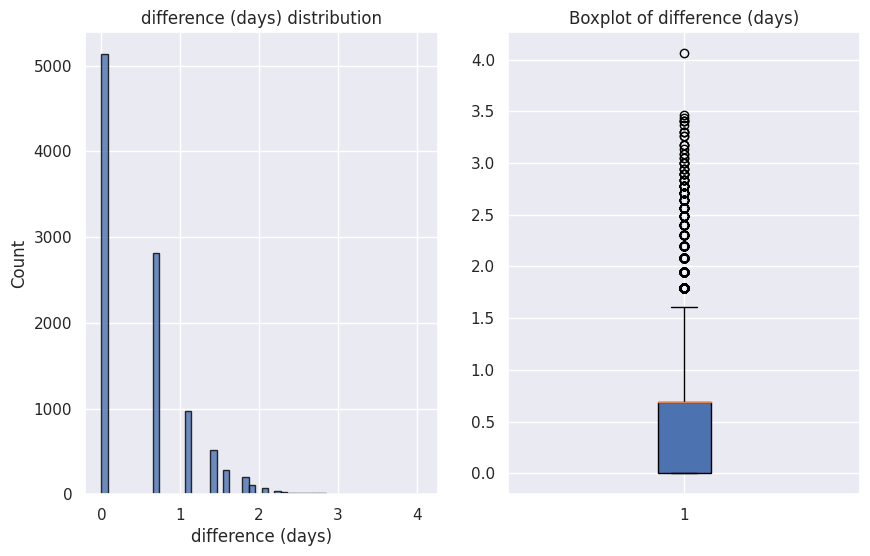

In [165]:
sns.set_theme("notebook")

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(np.log(new_df['Difference (days)']+1), bins=50, edgecolor='black', alpha=0.8)
# Ajouter des labels et un titre
plt.xlabel('difference (days)')
plt.ylabel('Count')
plt.title('difference (days) distribution')
# Afficher l'histogramme

plt.subplot(1, 2, 2)
plt.boxplot(np.log(new_df['Difference (days)']+1),patch_artist=True)
plt.title('Boxplot of difference (days)')    

plt.show()

In [166]:
df4 = new_df.copy()
df4['Difference (days)'] = np.log(df4['Difference (days)']+1)
df4.head()

,Statut,Motif du RDV,Date de saisie,Date de début,Difference (days)
0,Absent excusé,Adulte - Consultation de médecine générale,2022-12-29,2023-01-02,1.609438
4,Absent excusé,Adulte - Consultation de médecine générale,2022-12-30,2023-01-02,1.386294
5,Absent excusé,Adulte - Consultation de médecine générale,2023-01-01,2023-01-02,0.693147
8,Absent excusé,Adulte - Consultation de médecine générale,2022-12-30,2023-01-02,1.386294
9,Absent excusé,Adulte - Consultation de médecine générale,2022-12-29,2023-01-02,1.609438


/home/wang/miniforge3/envs/optim/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<AxesSubplot: xlabel='Statut', ylabel='Difference (days)'>

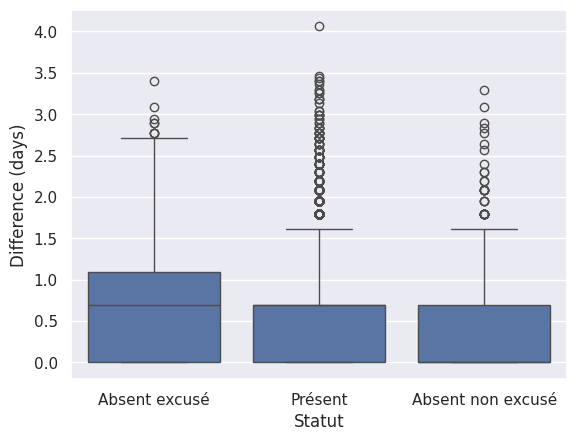

In [171]:
sns.boxplot(x="Statut", y="Difference (days)", data=df4)

In [172]:
grouped = df4.groupby(['Statut']).agg({'Difference (days)': ['mean', 'std']})
grouped

Difference (days)          
                               mean       std
Statut                                       
Absent excusé              0.664779  0.774552
Absent non excusé          0.498469  0.612141
Présent                    0.516079  0.614702

In [176]:
from scipy.stats import chi2_contingency

# Assuming 'var1' and 'var2' are the names of your variables
# Use pd.cut function can attribute the values into its specific bins
DD = pd.cut(df4['Difference (days)'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9+'])
contingency_table = pd.crosstab(DD, df4['Statut'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("chi2 statistic", chi2)
print("p-value", p)
print("degrees of freedom", dof)

chi2 statistic 51.80775320363223
p-value 1.8332571170868272e-08
degrees of freedom 8
